In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from tqdm import tqdm
import shutil
from utils import count_parameters, accuracy, pooling
from config import NUM_EPOCHS, CV_DATA

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam, ClippedAdam, SGD

from bayesian_vae import *

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.style.use('ggplot')

In [4]:
%matplotlib inline

In [5]:
state = torch.load('nn_state.pth.tar')

In [6]:
mdl = VAE()

In [7]:
mdl.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [8]:
mdl.eval()

VAE(
  (encoder): ConvEnc(
    (c1): Conv1d(1, 5, kernel_size=(3,), stride=(1,), padding=(1,))
    (c2): Conv1d(5, 10, kernel_size=(3,), stride=(1,), padding=(1,))
    (act): LeakyReLU(negative_slope=0.25)
    (pool): AdaptiveMaxPool1d(output_size=10)
    (fc_scale): Linear(in_features=100, out_features=50, bias=True)
    (fc_loc): Linear(in_features=100, out_features=50, bias=True)
  )
  (decoder): ConvDec(
    (c1): Conv1d(10, 5, kernel_size=(3,), stride=(1,), padding=(1,))
    (c2): Conv1d(5, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (fc): Linear(in_features=50, out_features=100, bias=True)
    (act): LeakyReLU(negative_slope=0.25)
    (softplus): Softplus(beta=1, threshold=20)
    (sigmoid): Sigmoid()
  )
)

In [9]:
cv_loader = torch.load('vae_cv_loader.pt')

In [10]:
cv_xs = next(iter(cv_loader))

In [26]:
x = cv_xs[40]
x = x.unsqueeze(0)

In [27]:
with torch.no_grad():
    res = mdl.reconstruct(x)

In [28]:
res = res.detach().cpu().numpy()

In [29]:
x = x.detach().cpu().numpy().reshape(-1)

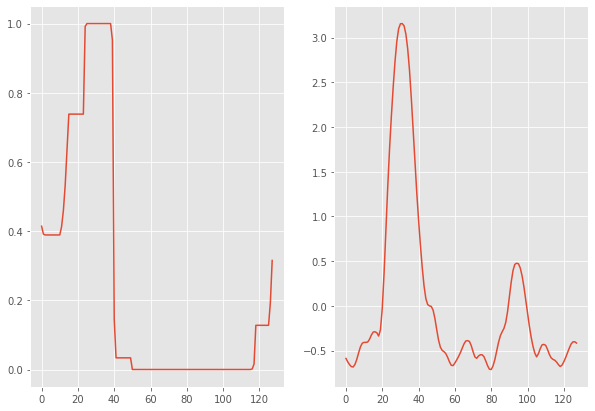

In [30]:
f, axes = plt.subplots(1, 2, figsize=(10,7))
sns.lineplot(x=np.arange(len(res)), y=res, ax=axes[0])
sns.lineplot(x=np.arange(len(x)), y=x, ax=axes[1])

### Latent Representation

In [31]:
zs = []
for x in cv_loader:
    zs.append(mdl.encoder(x))

In [32]:
len(zs)

6

In [37]:
zs[0][0].shape

torch.Size([50, 50])

In [38]:
len(cv_loader)

6